# Giới thiệu đề tài: Hybrid trong hệ thống gợi ý phim

Trong bối cảnh bùng nổ dữ liệu hiện nay, người dùng ngày càng gặp khó khăn trong việc lựa chọn thông tin phù hợp giữa một khối lượng lớn nội dung. Các hệ thống tư vấn (Recommender Systems) ra đời nhằm hỗ trợ người dùng trong quá trình ra quyết định, đặc biệt trong các lĩnh vực như thương mại điện tử, giải trí và học tập trực tuyến.

Tuy nhiên, các phương pháp gợi ý truyền thống như lọc cộng tác (Collaborative Filtering) và lọc dựa trên nội dung (Content-Based Filtering) đều tồn tại những điểm hạn chế nhất định. Ví dụ, lọc cộng tác thường gặp vấn đề dữ liệu thưa và cold-start đối với người dùng hoặc sản phẩm mới, trong khi lọc nội dung lại thiếu tính đa dạng và khó thích nghi với sở thích người dùng thay đổi theo thời gian.

Từ thực tiễn đó, nhóm quyết định lựa chọn đề tài Hybrid trong hệ thống gợi ý, với mục tiêu kết hợp điểm mạnh của cả hai phương pháp trên nhằm xây dựng một hệ thống tư vấn toàn diện hơn, có khả năng cá nhân hóa tốt và nâng cao độ chính xác trong đề xuất.


## Dataset

 Để xây dựng mô hình hệ thống tư vấn, nhóm đã lựa chọn bộ dữ liệu MovieLens. Bộ dữ liệu này được thu thập và
 phát hành bởi nhóm nghiên cứu GroupLens thuộc Đại học Minnesota từ dịch vụ tư vấn phim trực tuyến MovieLens.

  [Dataset MovieLens 10M](https://grouplens.org/datasets/movielens/10m/)

# Import Libraryb and Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix

In [ ]:
# Đọc ratings.dat
ratings = pd.read_csv("ratings.dat",
                      sep="::",
                      engine="python",
                      names=["userId", "movieId", "rating", "timestamp"])

# Đọc movies.dat
movies = pd.read_csv("movies.dat",
                     sep="::",
                     engine="python",
                     names=["movieId", "title", "genres"])

tags = pd.read_csv("tags.dat",
                     sep="::",
                     engine="python",
                     names =["userId", "movieId", "tag", "timestamp"])


In [ ]:
print("="*50)
print("THỐNG KÊ DỮ LIỆU")
print("="*50)
print(f"Ratings: {ratings.shape[0]} đánh giá, {ratings['userId'].nunique()} người dùng")
print(f"Movies: {movies.shape[0]} phim")

THỐNG KÊ DỮ LIỆU
Ratings: 10000054 đánh giá, 69878 người dùng
Movies: 10681 phim


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


# Exploratory Data Analyst

## Rating

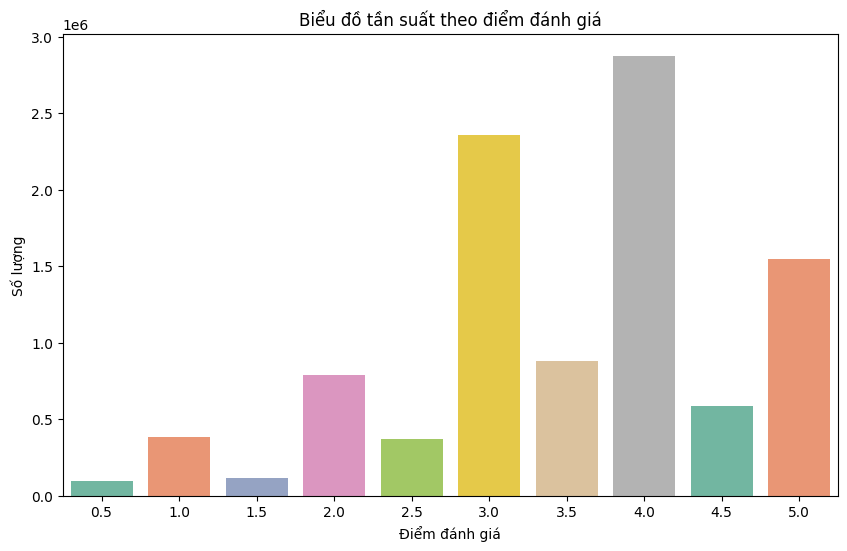

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.countplot(data=ratings, x='rating', palette='Set2')
plt.title('Biểu đồ tần suất theo điểm đánh giá')
plt.xlabel('Điểm đánh giá')
plt.ylabel('Số lượng')
plt.show()

**Nhận xét:**

- Phần lớn các đánh giá tập trung ở mức cao, từ 3.0 đến 5.0, với sự sụt giảm rõ rệt ở các mức ratings thấp.
- Rating 4.0 là phổ biến nhất với số lượng đánh giá cao nhất, tiếp theo là rating 5.0 và 3.0 với tần suất đáng kể. Các mức ratings thấp (0.5, 1.0, 1.5) có tần suất rất thấp, gần như không đáng kể.
- Mặc dù rating 2.0, 2.5, và 3.5 có số lượng đánh giá thấp hơn so với các mức cao, nhưng chúng vẫn xuất hiện với tần suất đủ để phản ánh một phần ý kiến trung lập hoặc không hoàn toàn hài lòng.

=> Dữ liệu cho thấy xu hướng đánh giá rất tích cực, với phần lớn người dùng hài lòng (ratings từ 4.0 trở lên chiếm ưu thế). Các đánh giá tiêu cực (dưới 2.0) gần như không tồn tại, và các đánh giá trung bình (2.0–3.0) cũng rất hạn chế. Điều này có thể gợi ý rằng phim trong bộ dữ liệu được đánh giá cao và nhận được phản hồi tích cực từ hầu hết người dùng, với rất ít ý kiến không hài lòng.


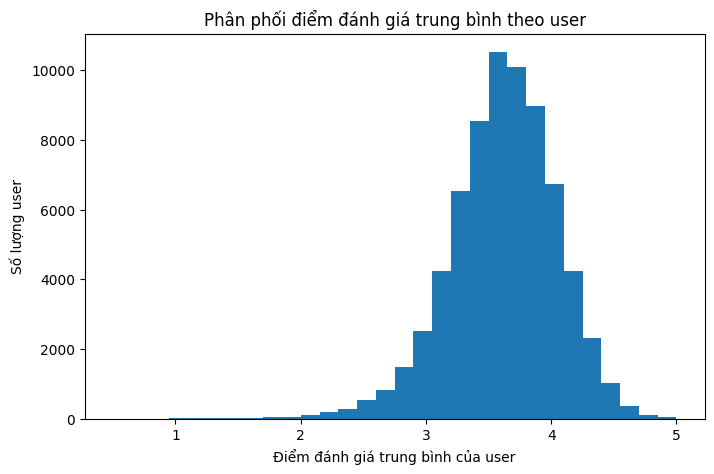

In [ ]:
user_avg_ratings = ratings.groupby('userId')['rating'].mean()
plt.figure(figsize=(8, 5))
user_avg_ratings.hist(bins=30,grid = False)
plt.xlabel('Điểm đánh giá trung bình của user')
plt.ylabel('Số lượng user')
plt.title('Phân phối điểm đánh giá trung bình theo user')
plt.show()

**Nhận xét**:

Phân bố gần dạng chuẩn, tập trung chủ yếu quanh giá trị trung bình ~3.7 điểm, cho thấy người dùng thường cho điểm ở mức khá cao. Nhưng vẫn có 1 bộ phận nhỏ đánh giá khá khó tính và dễ tính, nên chú ý để scale cho hợp lý khi xây dựng mô hình.


## Movie

**Top 20 bộ phim có số lượt đánh giá nhiều nhất**

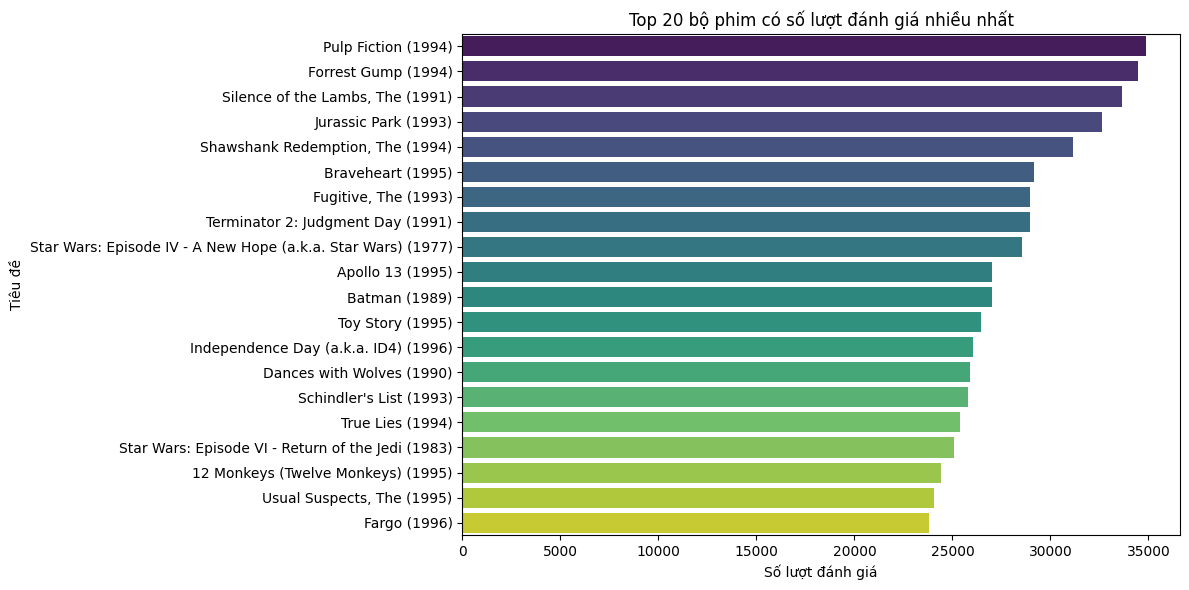

In [ ]:
# Lấy danh sách 20 bộ phim có số lượt đánh giá cao nhất
top_movies = ratings['movieId'].value_counts().head(20)
# Tạo DataFrame
top_movies = pd.DataFrame({'movieId': top_movies.index, 'num_ratings': top_movies.values})
# Gộp dữ liệu với bảng 'movies' để lấy tên phim
top_movies = top_movies.merge(movies[['movieId', 'title']], on='movieId')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(y='title', x='num_ratings', data=top_movies, palette='viridis')
plt.title('Top 20 bộ phim có số lượt đánh giá nhiều nhất')
plt.xlabel('Số lượt đánh giá')
plt.ylabel('Tiêu đề')
plt.tight_layout()
plt.show()

**Nhận xét:**

- Phần lớn các bộ phim trong top 20 có số lượt đánh giá cao nằm trong khoảng từ 15,000 đến hơn 30,000 lượt, cho thấy sự phổ biến và quan tâm lớn từ người dùng.
- Các bộ phim có số lượt đánh giá cao nhất đều thuộc nhóm phim kinh điển hoặc nổi tiếng toàn cầu trong thập niên 80 và 90, phản ánh sự yêu thích bền vững của khán giả đối với các tác phẩm này.
- Pulp Fiction (1994), Forrest Gump (1994) và The Silence of the Lambs (1991) dẫn đầu về số lượng đánh giá, cho thấy mức độ phổ biến và tầm ảnh hưởng rộng rãi của các bộ phim này.

=> Biểu đồ phản ánh rõ ràng mức độ phổ biến của các bộ phim kinh điển qua số lượt đánh giá cao. Điều này có thể liên quan đến mức độ tiếp cận rộng rãi, độ nổi tiếng của đạo diễn, diễn viên và giá trị nội dung của phim. Đồng thời, dữ liệu cũng cho thấy các tác phẩm phát hành vào thập niên 90 có ảnh hưởng mạnh mẽ và ghi dấu ấn sâu đậm trong lòng khán giả toàn cầu.


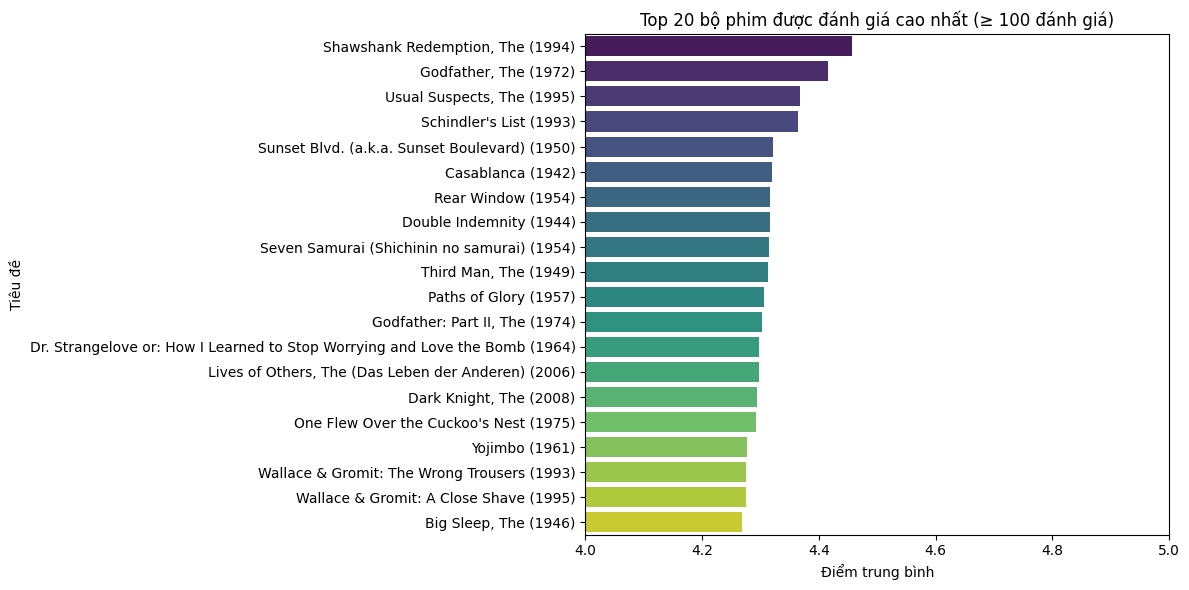

In [ ]:
# Tính điểm trung bình và số lượt đánh giá cho từng phim
movie_stats = ratings.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

# Lọc các bộ phim có ít nhất 100 đánh giá
popular_movies = movie_stats[movie_stats['rating_count'] >= 100]
# Lấy 20 bộ phim có điểm trung bình cao nhất
top_rated = popular_movies.sort_values(by='avg_rating', ascending=False).head(20)
# Gộp với bảng 'movies' để lấy title của phim
top_rated = top_rated.merge(movies[['movieId', 'title']], on='movieId')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(x='avg_rating', y='title', data=top_rated, palette='viridis')
plt.title('Top 20 bộ phim được đánh giá cao nhất (≥ 100 đánh giá)')
plt.xlabel('Điểm trung bình')
plt.ylabel('Tiêu đề')
plt.xlim(4, 5)
plt.tight_layout()
plt.show()

**Nhận xét:**

=> Dữ liệu cho thấy xu hướng đánh giá rất tích cực, với phần lớn các bộ phim kinh điển và có ảnh hưởng lớn đạt điểm trung bình cao (4.4 trở lên), phản ánh sự công nhận từ cộng đồng người dùng

## Genres

In [ ]:
# Nối dữ liệu từ bảng 'ratings' và 'movies'
merged = ratings.merge(movies, on='movieId')
# Loại bỏ các bộ phim không có thể loại
merged = merged[merged['genres'] != '(no genres listed)']
# Tách các thể loại thành list rồi tách thành các dòng riêng biệt
merged['genres'] = merged['genres'].str.split('|')
exploded = merged.explode('genres')
exploded.head()

,userId,movieId,rating,timestamp,title,genres
0,1,122,5.0,838985046,Boomerang (1992),Comedy
0,1,122,5.0,838985046,Boomerang (1992),Romance
1,1,185,5.0,838983525,"Net, The (1995)",Action
1,1,185,5.0,838983525,"Net, The (1995)",Crime
1,1,185,5.0,838983525,"Net, The (1995)",Thriller


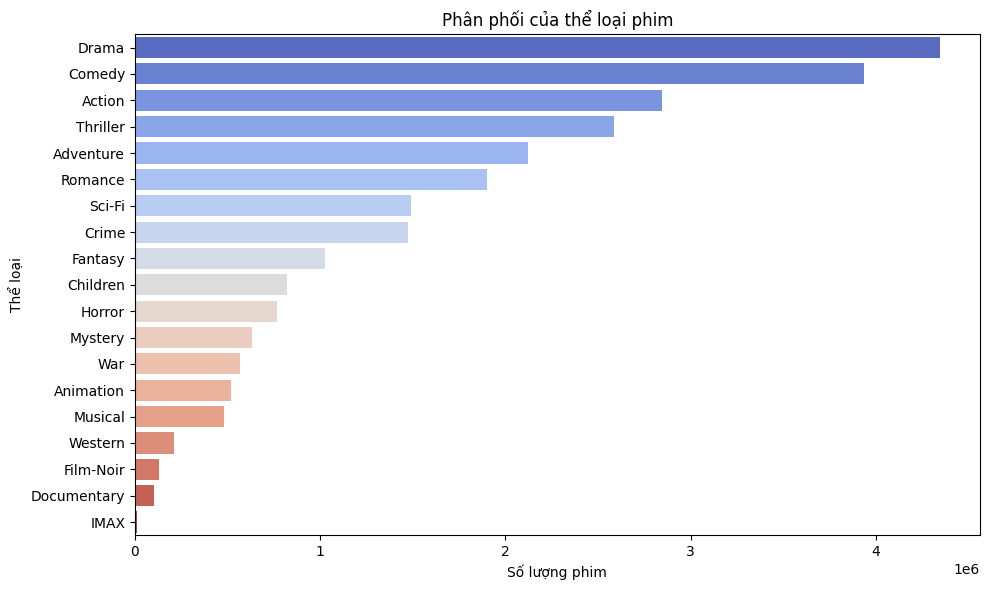

In [ ]:
# Đếm số lượng phim theo từng thể loại
genre_counts = exploded['genres'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_counts, x='count', y='genre', palette='coolwarm')
plt.title('Phân phối của thể loại phim')
plt.xlabel('Số lượng phim')
plt.ylabel('Thể loại')
plt.tight_layout()
plt.show()

**Nhận xét:**

=> Có một sự chênh lệch lớn về số lượng giữa các thể loại hàng đầu và các thể loại ở cuối danh sách. Phân phối cho thấy sự tập trung đáng kể vào các thể loại truyền thống và phổ biến rộng rãi như chính kịch, hài và hành động, trong khi các thể loại chuyên biệt hơn như Film-Noir hoặc Documentary có số lượng khiêm tốn hơn nhiều. Thông tin này có thể hữu ích cho việc hiểu thị trường phim, xu hướng sản xuất hoặc sở thích chung của khán giả.

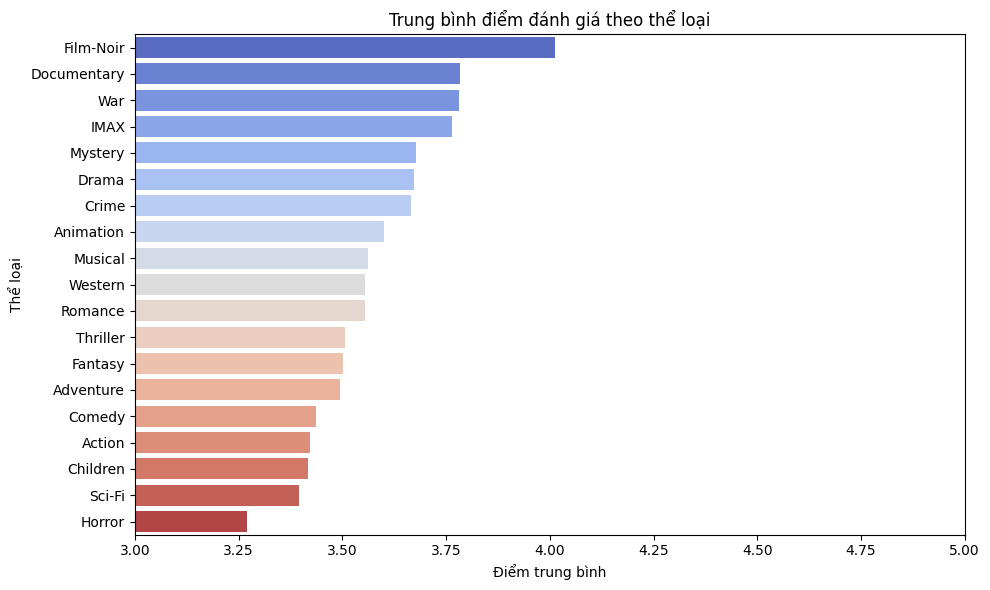

In [ ]:
# Tính trung bình điểm đánh giá theo thể loại phim
genre_avg = exploded.groupby('genres')['rating'].mean().reset_index()
genre_avg.columns = ['genre', 'avg_rating']
# Sắp xếp điểm trung bình từ cao đến thấp
genre_avg = genre_avg.sort_values(by='avg_rating', ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_avg, x='avg_rating', y='genre', palette='coolwarm')
plt.title('Trung bình điểm đánh giá theo thể loại')
plt.xlabel('Điểm trung bình')
plt.ylabel('Thể loại')
plt.xlim(3, 5)
plt.tight_layout()
plt.show()

**Nhận xét:**

=> Dữ liệu cho thấy xu hướng đánh giá tích cực tổng thể, với các thể loại như Film-Noir, Documentary, và War nhận được sự yêu thích cao nhất. Thể loại Horror có điểm trung bình thấp nhất, có thể do sự phân cực trong phản hồi từ người dùng. Điều này có thể phản ánh sự khắt khe hơn của người xem với các dòng phim giải trí hoặc sự thiếu đồng đều về chất lượng trong các thể loại đại chúng. Các thể loại nghệ thuật, tư duy cao thường nhận được sự công nhận mạnh mẽ hơn từ cộng đồng đánh giá.

## Timestamp

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


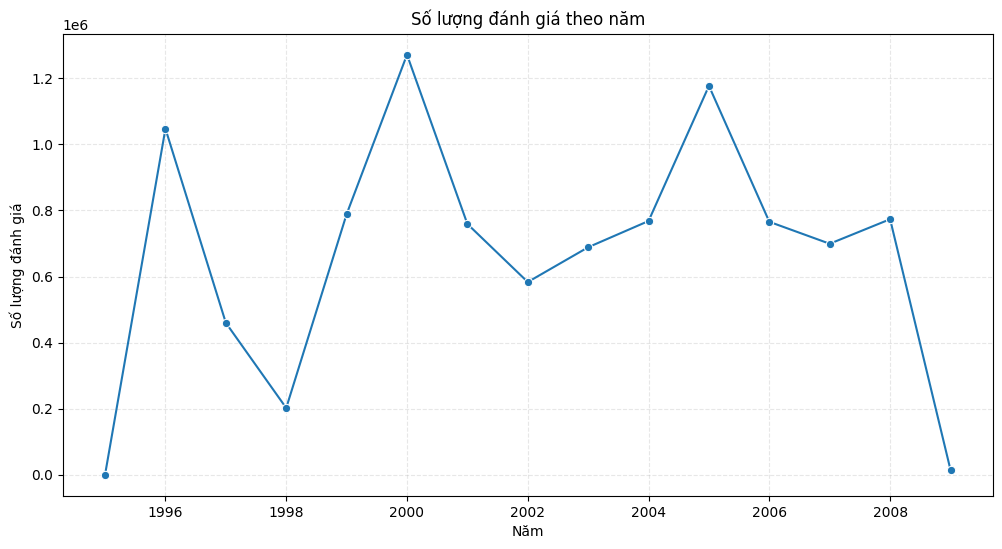

In [ ]:
# Chuyển cột 'timestamp' sang kiểu datetime và lấy năm
ratings['year'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.year
# Đếm số đánh giá theo từng năm
ratings_by_year = ratings['year'].value_counts().sort_index()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.lineplot(x=ratings_by_year.index, y=ratings_by_year.values, marker='o')
plt.title('Số lượng đánh giá theo năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng đánh giá')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

**Nhận xét:**

=> Nhìn chung, biểu đồ cho thấy xu hướng dao động rõ rệt theo từng chu kỳ, trong đó các đỉnh tăng trưởng thường rơi vào các năm có dấu ấn lớn về điện ảnh, còn các giai đoạn suy giảm có thể do ảnh hưởng từ thị trường phim ảnh hoặc các yếu tố kỹ thuật trong việc ghi nhận dữ liệu.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


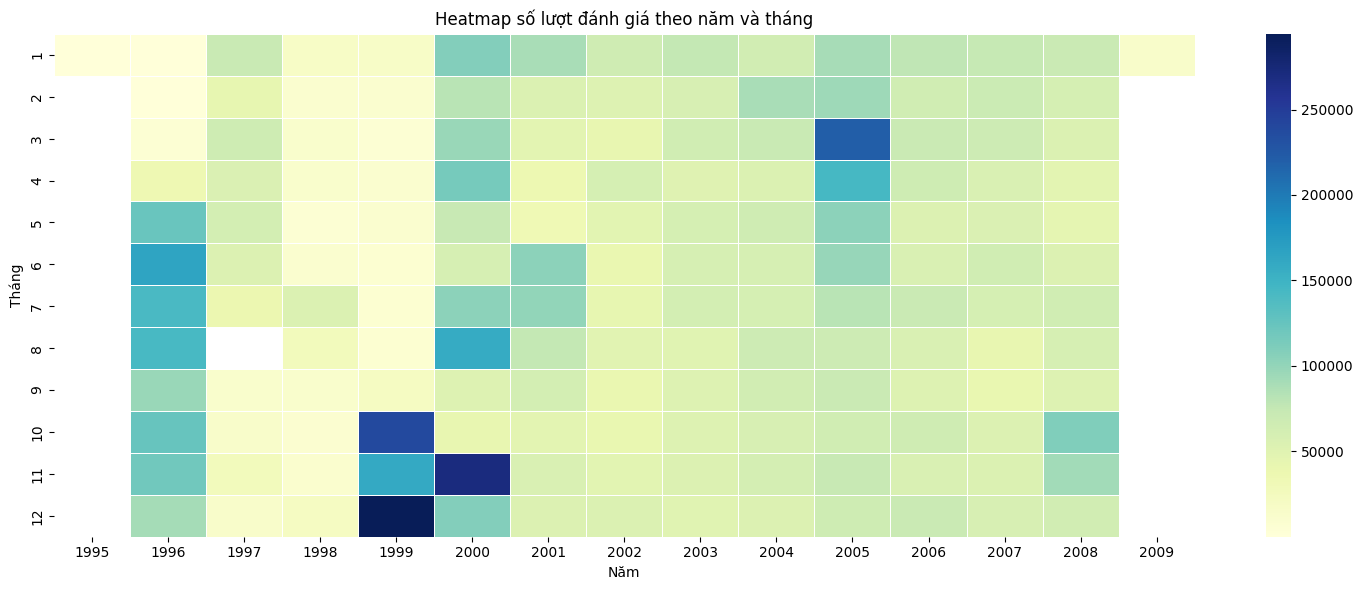

In [ ]:
# Chuyển cột 'timestamp' sang kiểu datetime và lấy theo tháng (Year-Month)
ratings['year_month'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.to_period('M')
# Đếm số lượt đánh giá theo tháng và năm
ratings_heatmap = ratings.groupby(ratings['year_month']).size().reset_index(name='count')
ratings_heatmap['year'] = ratings_heatmap['year_month'].dt.year
ratings_heatmap['month'] = ratings_heatmap['year_month'].dt.month

# Tạo bảng pivot với tháng là index và năm là cột
pivot_table = ratings_heatmap.pivot(index='month', columns='year', values='count')

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5, annot=False)
plt.title('Heatmap số lượt đánh giá theo năm và tháng')
plt.xlabel('Năm')
plt.ylabel('Tháng')
plt.tight_layout()
plt.show()

**Nhận xét:**

=> Biểu đồ heatmap phản ánh xu hướng đánh giá tập trung theo mùa, với cao điểm thường rơi vào quý IV (tháng 10 đến 12) và rải rác ở một số năm vào mùa hè (tháng 6–8). Dữ liệu này có thể gợi ý rằng các hệ thống đánh giá nên tập trung nguồn lực vào các tháng cuối năm để tối ưu hiệu suất hệ thống hoặc chiến dịch quảng bá phim ảnh, đồng thời cho thấy mức độ quan tâm của người dùng tăng cao khi bước vào kỳ nghỉ lễ cuối năm.

## Sparsity

Cosine similarity hoạt động kém trên dữ liệu thưa thớt vì các vector người dùng/phim có ít giá trị chung để tính toán. Độ thưa thớt cao (thường ~98–99% trong MovieLens) yêu cầu các kỹ thuật như giảm chiều (SVD) hoặc xử lý đặc biệt.

Độ thưa thớt: 0.9866 (chỉ 1.3403% ô có giá trị)
Người dùng cold-start (<5 đánh giá): 0 (0.00%)
Phim cold-start (<5 đánh giá): 481 (4.51%)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


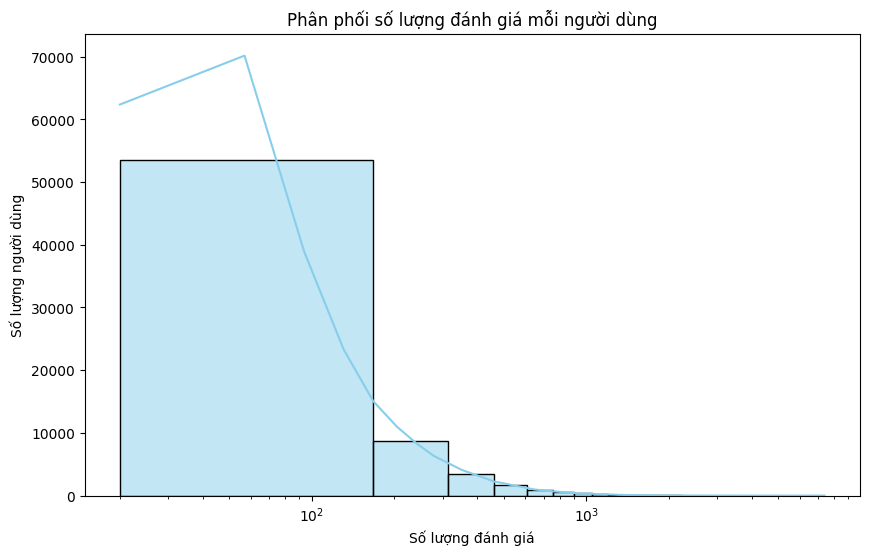

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


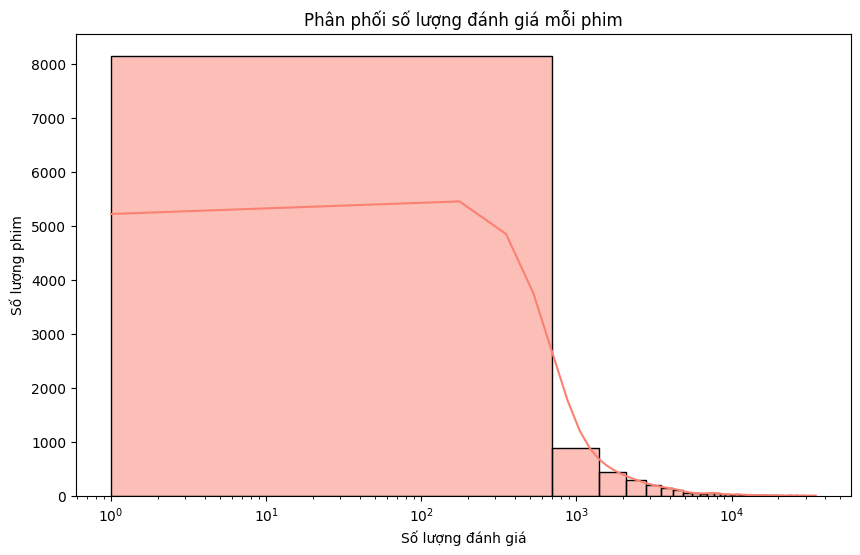

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tính độ thưa thớt
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)
sparsity = 1 - n_ratings / (n_users * n_movies)
print(f"Độ thưa thớt: {sparsity:.4f} (chỉ {1-sparsity:.4%} ô có giá trị)")

# Phân tích cold-start
user_rating_counts = ratings['userId'].value_counts()
movie_rating_counts = ratings['movieId'].value_counts()
cold_start_users = user_rating_counts[user_rating_counts < 5]
cold_start_movies = movie_rating_counts[movie_rating_counts < 5]
print(f"Người dùng cold-start (<5 đánh giá): {len(cold_start_users)} ({len(cold_start_users)/n_users:.2%})")
print(f"Phim cold-start (<5 đánh giá): {len(cold_start_movies)} ({len(cold_start_movies)/n_movies:.2%})")

# Vẽ phân phối số lượng đánh giá
plt.figure(figsize=(10, 6))
sns.histplot(user_rating_counts, bins=50, kde=True, color='skyblue')
plt.title('Phân phối số lượng đánh giá mỗi người dùng')
plt.xlabel('Số lượng đánh giá')
plt.ylabel('Số lượng người dùng')
plt.xscale('log')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(movie_rating_counts, bins=50, kde=True, color='salmon')
plt.title('Phân phối số lượng đánh giá mỗi phim')
plt.xlabel('Số lượng đánh giá')
plt.ylabel('Số lượng phim')
plt.xscale('log')
plt.show()

**Nhận xét:**

- Phần lớn các người dùng (hơn 50,000 người) có số lượng đánh giá nằm trong khoảng 10 đến 100 lượt, thể hiện mức độ hoạt động đánh giá trung bình, với đỉnh cao nhất ở khoảng 50–100 lượt, nơi có số lượng người dùng lớn nhất (gần 60,000 người).
- Số lượng người dùng giảm dần khi số lượt đánh giá tăng trên 100, với một số ít người dùng có hơn 1,000 lượt đánh giá, cho thấy sự hiếm hoi của người dùng siêu tích cực.
- Đường cong tích lũy cho thấy sự phân bố không đồng đều, với phần lớn người dùng tập trung ở số lượng đánh giá thấp (dưới 100), trong khi số lượng người dùng giảm mạnh khi vượt qua ngưỡng này.

=> Dữ liệu phản ánh sự phân bố không đồng đều của số lượt đánh giá giữa các người dùng, với phần lớn thuộc nhóm có hoạt động đánh giá hạn chế (10–100 lượt), trong khi chỉ một số ít người dùng rất tích cực (trên 1,000 lượt). Điều này phù hợp với độ thưa thớt 98.66%, cho thấy ma trận người dùng-phim rất thưa, và không có người dùng cold-start (<5 đánh giá) là một lợi thế cho hệ thống gợi ý Hybrid.

## Tag

Top 20 thẻ phổ biến:
tag
Tumey's DVDs                641
classic                     621
based on a book             549
R                           518
less than 300 ratings       505
70mm                        464
Nudity (Topless)            464
erlend's DVDs               405
Oscar (Best Picture)        400
comedy                      396
seen more than once         381
action                      374
sci-fi                      358
movie to see                345
imdb top 250                318
Disney                      314
Nudity (Topless - Brief)    309
World War II                309
Betamax                     293
Can't remember              293
Name: count, dtype: int64


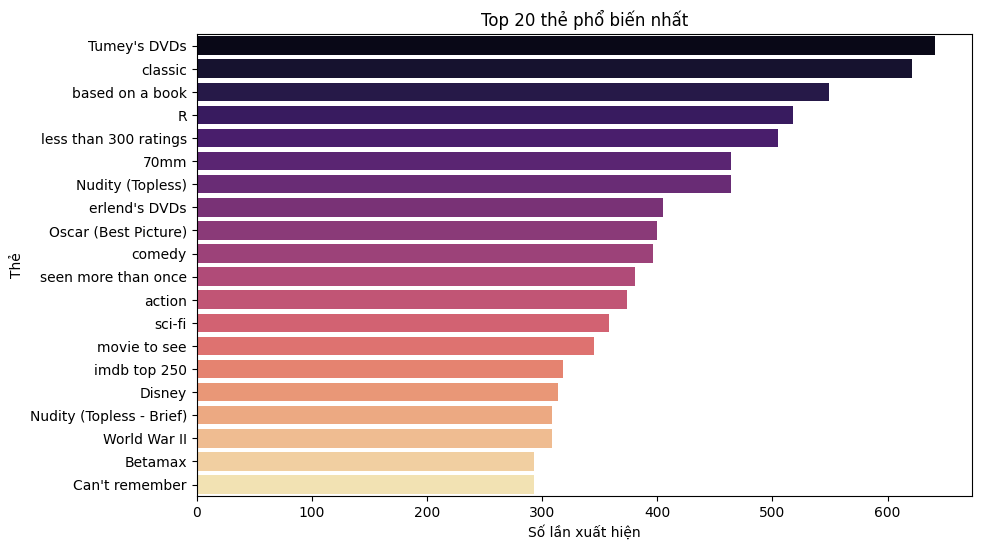

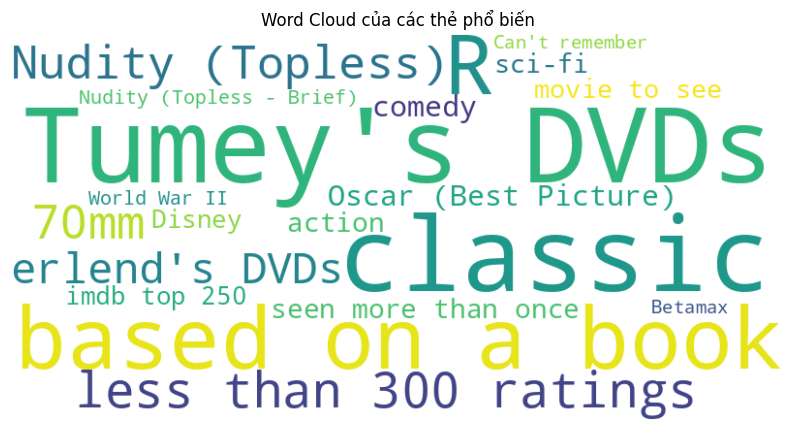

In [ ]:
from wordcloud import WordCloud

# Đếm thẻ phổ biến
tag_counts = tags['tag'].value_counts().head(20)
print("Top 20 thẻ phổ biến:")
print(tag_counts)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='magma')
plt.title('Top 20 thẻ phổ biến nhất')
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Thẻ')
plt.show()

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud của các thẻ phổ biến')
plt.show()



**Nhận xét:**

=> Dữ liệu cho thấy sự kết hợp giữa các thẻ mô tả nội dung (như "classic", "comedy") và các thẻ mang tính cá nhân hoặc meta (như "Tumey's DVDs", "Oscar"), phản ánh sự đa dạng trong cách người dùng gắn thẻ. Điều này rất hữu ích cho hệ thống gợi ý Hybrid, đặc biệt khi kết hợp với CBF unconstrained, vì tags như "action" hay "sci-fi" có thể làm giàu đặc trưng nội dung, trong khi các thẻ cá nhân hóa (như "seen more than once") hỗ trợ cá nhân hóa gợi ý. Tuy nhiên, cần làm sạch các thẻ không mang nội dung trực tiếp (như "Tumey's DVDs") để tối ưu hóa hiệu quả,

Số thẻ duy nhất: 16528
Số phim có ít nhất một thẻ: 7601 (71.19%)


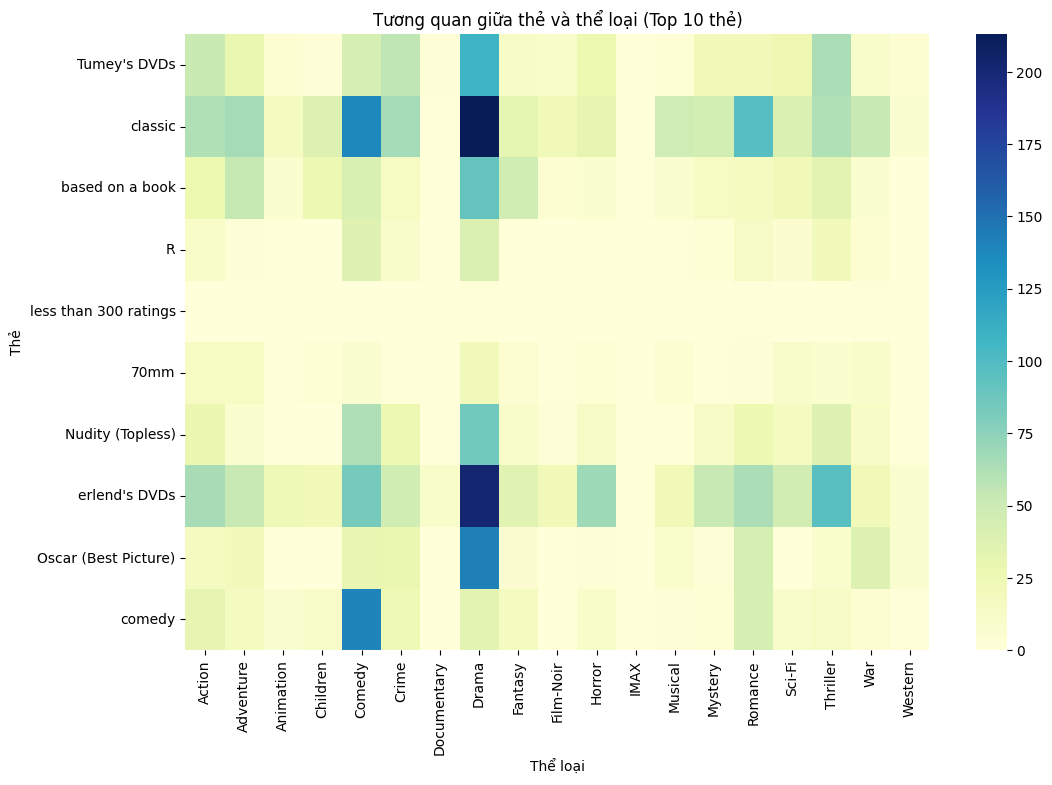

In [ ]:
# Tính số thẻ duy nhất và số phim được gán thẻ
unique_tags = tags['tag'].nunique()
movies_with_tags = tags['movieId'].nunique()
print(f"Số thẻ duy nhất: {unique_tags}")
print(f"Số phim có ít nhất một thẻ: {movies_with_tags} ({movies_with_tags/n_movies:.2%})")

# Phân tích tags theo genres
merged_tags = tags.merge(ratings, on=['userId', 'movieId']).merge(movies, on='movieId')
merged_tags['genres'] = merged_tags['genres'].str.split('|')
exploded_tags = merged_tags.explode('genres')
tag_genre_counts = exploded_tags.groupby(['tag', 'genres']).size().unstack().fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(tag_genre_counts.loc[tag_counts.index[:10]], cmap='YlGnBu')
plt.title('Tương quan giữa thẻ và thể loại (Top 10 thẻ)')
plt.xlabel('Thể loại')
plt.ylabel('Thẻ')
plt.show()

**Nhận xét:**

=> Dữ liệu cho thấy sự tập trung của các thẻ phổ biến vào các thể loại chính như Drama và Comedy, phản ánh sở thích đa dạng của người dùng và sự liên quan của tags với các phim nổi bật. Với số thẻ duy nhất là 16,528 và 7,601 phim (71.19%) có ít nhất một thẻ, tags cung cấp một nguồn đặc trưng nội dung phong phú cho hệ thống gợi ý Hybrid

# Preprocessing


In [ ]:
# Tính tỷ lệ phần trăm giá trị bị thiếu
def calculate_missing_data(data):
    missing_df = pd.DataFrame({
        'column_name': data.columns,
        'total_missing': data.isnull().sum(),
        '%_missing': data.isnull().sum() * 100 / len(data)
    }).reset_index(drop=True)
    missing_df = missing_df.sort_values('%_missing', ascending=False)

    return missing_df

In [ ]:
# Kiểm tra giá trị thiếu của 'ratings'
calculate_missing_data(ratings)

,column_name,total_missing,%_missing
0,userId,0,0.0
1,movieId,0,0.0
2,rating,0,0.0
3,timestamp,0,0.0
4,year,0,0.0
5,year_month,0,0.0


In [ ]:
# Kiểm tra giá trị thiếu của 'tags'
calculate_missing_data(tags)

,column_name,total_missing,%_missing
2,tag,16,0.01674
0,userId,0,0.00000
1,movieId,0,0.00000
3,timestamp,0,0.00000


In [ ]:
# Kiểm tra giá trị thiếu của 'movies'
calculate_missing_data(movies)

,column_name,total_missing,%_missing
0,movieId,0,0.0
1,title,0,0.0
2,genres,0,0.0


In [ ]:
# Thay tag NaN hoặc có kí tự non-ASCII bằng chuỗi rỗng
tags["tag"] = tags["tag"].fillna("")
tags["tag"] = tags["tag"].apply(lambda x: x if str(x).isascii() else "")
# Gộp tag theo movieId
tags_agg = tags.groupby("movieId")["tag"].apply(lambda x: " ".join(set(x))).reset_index()

In [ ]:
# Tách năm từ cột 'title'
movies["year"] = movies["title"].str.extract(r"(\d{4})")
# Xóa năm khỏi cột 'title'
movies["title"] = movies["title"].str.replace(r"\(\d{4}\)", "", regex=True).str.strip()
# Tách genres thành danh sách
movies = movies[movies['genres'] != '(no genres listed)'].copy()
movies['genres'] = movies['genres'].str.split('|')

In [ ]:
# Ghép vào bảng movies và tạo cột 'text' chứa title, genres, tag
movies = movies.merge(tags_agg, on="movieId", how="left")
movies["tag"] = movies["tag"].fillna("")
movies["text"] = (
    movies["title"] + " " +
    movies["genres"].apply(lambda x: " ".join(x)) + " " +
    movies["tag"]
)
movies

,movieId,title,genres,year,tag,text
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,animation humorous bright clever erlend's DVD...,Toy Story Adventure Animation Children Comedy ...
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,kid flick Kirsten Dunst animals Saturn Award (...,Jumanji Adventure Children Fantasy kid flick K...
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,old people that is actually funny moldy Jack ...,Grumpier Old Men Comedy Romance old people th...
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,girl movie,Waiting to Exhale Comedy Drama Romance girl movie
4,5,Father of the Bride Part II,[Comedy],1995,remake childhood classics watched under duress...,Father of the Bride Part II Comedy remake chil...
...,...,...,...,...,...,...
10675,65088,Bedtime Stories,"[Adventure, Children, Comedy]",2008,,Bedtime Stories Adventure Children Comedy
10676,65091,Manhattan Melodrama,"[Crime, Drama, Romance]",1934,,Manhattan Melodrama Crime Drama Romance
10677,65126,Choke,"[Comedy, Drama]",2008,Chuck Palahniuk based on book,Choke Comedy Drama Chuck Palahniuk based on book
10678,65130,Revolutionary Road,"[Drama, Romance]",2008,toplist08,Revolutionary Road Drama Romance toplist08


In [ ]:
calculate_missing_data(movies)

,column_name,total_missing,%_missing
0,movieId,0,0.0
1,title,0,0.0
2,genres,0,0.0
3,year,0,0.0
4,tag,0,0.0
5,text,0,0.0


In [ ]:
ratings['mean_user'] = ratings.groupby('userId')['rating'].transform('mean')
ratings['std_user'] = ratings.groupby('userId')['rating'].transform('std').replace(0, 1e-8)
ratings['z_rating'] = (ratings['rating'] - ratings['mean_user']) / ratings['std_user']

In [ ]:
ratings.sample(5)

,userId,movieId,rating,timestamp,mean_user,std_user,z_rating
1000526,7525,337,2.0,839541210,3.317757,0.830982,-1.585783
1328324,9757,589,4.0,1089027486,3.604651,1.167813,0.338538
563453,4319,292,5.0,828124616,3.982759,0.826987,1.230057
378766,2941,296,4.0,839225812,4.018182,1.113734,-0.016325
1334637,9809,1197,1.0,949903429,3.123377,1.197448,-1.773252


# Building Recommender System

## Content - Based

## Indentified class ContentBasedRecommender

Hàm này sẽ thực hiện các bước sau:
1. Text Vetorization
2. Feature Selection
3. Xây dựng User Profile
4. Tính cosine similarity
5. Dự đoán rating

**Term Frequency – Inverse Document Frequency (TF-IDF)**

TF-IDF là một kỹ thuật phổ biến trong khai phá văn bản nhằm biểu diễn mức độ quan trọng của một từ trong một văn bản so với toàn bộ tập tài liệu. Phương pháp này kết hợp hai yếu tố:

- **Term Frequency (TF)**: số lần xuất hiện của từ trong văn bản  
- **Inverse Document Frequency (IDF)**: đo độ hiếm của từ trong toàn bộ tập dữ liệu

Công thức TF-IDF:

$$
\text{tfidf}_{i,j} = \text{tf}_{i,j} \cdot \log\left( \frac{N}{\text{df}_i + 1} \right)
$$

Trong đó:

- $ \text{tf}_{i,j} $ : số lần từ $ i $ xuất hiện trong văn bản $ j $
- $ \text{df}_i $ : số văn bản chứa từ $ i $  
- $ N $ : tổng số văn bản trong tập dữ liệu  

$\Rightarrow$ Mục tiêu: tăng trọng số cho các từ đặc trưng (ít xuất hiện) và giảm trọng số cho các từ phổ biến.

**Supervised Feature Selection using Chi-squared Test**

Chi-squared ($\chi^2$) là một kiểm định thống kê nhằm đánh giá mức độ phụ thuộc giữa hai biến rời rạc, trong đó một biến là đặc trưng (feature) và biến còn lại là nhãn phân loại.



$$
\chi^2(f) = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i}
$$

Trong đó:
- $O_i$: số lượng quan sát thực tế  
- $E_i$: số lượng quan sát kỳ vọng nếu không có quan hệ giữa feature và label

**Biểu diễn hồ sơ người dùng (User Profile Vector)**

Hồ sơ người dùng được xây dựng bằng cách lấy trung bình vector TF-IDF của các item (phim) mà người dùng đánh giá tích cực:

$$
\vec{u} = \frac{1}{|I_u^+|} \sum_{i \in I_u^+} \vec{x}_i
$$

Trong đó:
- $\vec{x}_i$: vector TF-IDF của phim $i$  
- $I_u^+$: tập các phim mà người dùng $u$ đánh giá tích cực (ví dụ: $z\_rating \geq 0$)

**Đo độ tương đồng bằng Cosine Similarity**

$$
\text{sim}(u, i) = \frac{\vec{u} \cdot \vec{x}_i}{\|\vec{u}\| \cdot \|\vec{x}_i\|}
$$

- $\vec{u}$: hồ sơ người dùng  
- $\vec{x}_i$: vector đặc trưng của item $i$  

Cosine similarity trả về giá trị trong khoảng $[0, 1]$, giá trị càng cao thì hai vector càng tương đồng.

**Dự đoán điểm đánh giá (Rating Prediction)**

$$
\hat{r}_{ui} = \mu_u + \alpha_u \cdot \text{sim}(u, i)
$$

Trong đó:
- $\mu_u$: trung bình điểm đánh giá của user i
- $\alpha_u$: hệ số mở rộng sao cho điểm đánh giá nằm trong khoảng hợp lệ  
- $\hat{r}_{ui}$: điểm đánh giá dự đoán  

Rating nên được ràng buộc trong khoảng $[0.5, 5]$.


In [ ]:
import pandas as pd
import numpy as np
import re
import math
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

def preprocess_text(text):
    text = text.lower()
    return re.findall(r'\b\w+\b', text)

class ContentBasedRecommender:
    def __init__(self, min_df=2, max_df_ratio=0.95, k_features=300, threshold=0.0, center=3.0, scale=2.0):
        self.min_df = min_df
        self.max_df_ratio = max_df_ratio
        self.k_features = k_features
        self.threshold = threshold
        self.center = center
        self.scale = scale
        self.tfidf_matrix = None
        self.movie_ids = None
        self.selector = None
        self.ratings = None
        self.user_means = {}  # Lưu trung bình rating từng user
        self.user_profiles = {}  # Lưu trữ user profiles đã tính toán
        self.user_alphas = {user_id: min(5.0 - mu, mu - 0.5)
                            for user_id, mu in self.user_means.items()}


    def tfidf_custom(self, documents):
        tokenized_docs = [preprocess_text(doc) for doc in documents]
        N = len(tokenized_docs)
        df_counts = defaultdict(int)
        for doc in tokenized_docs:
            for term in set(doc):
                df_counts[term] += 1

        allowed_terms = {
            term for term, df in df_counts.items()
            if df >= self.min_df and df <= self.max_df_ratio * N
        }
        idf = {
            term: math.log((N + 1) / (df_counts[term] + 1)) + 1
            for term in allowed_terms
        }
        self.feature_names = sorted(idf.keys())

        def compute_tf(tokens):
            tf = defaultdict(float)
            for word in tokens:
                tf[word] += 1
            total_terms = len(tokens)
            return {term: count / total_terms for term, count in tf.items()}

        tfidf_matrix = []
        for tokens in tokenized_docs:
            tf = compute_tf(tokens)
            tfidf_vector = [tf.get(term, 0.0) * idf[term] for term in self.feature_names]
            tfidf_matrix.append(tfidf_vector)

        tfidf_matrix = csr_matrix(tfidf_matrix)
        tfidf_matrix = normalize(tfidf_matrix, norm='l2', axis=1)
        return tfidf_matrix

    def feature_selection(self, ratings, movies, tfidf_matrix):
        ratings = ratings.copy()
        ratings['label'] = (ratings['z_rating'] >= 0).astype(int)
        movieid_to_index = {mid: idx for idx, mid in enumerate(movies['movieId'])}
        ratings['tfidf_index'] = ratings['movieId'].map(movieid_to_index)
        ratings = ratings.dropna(subset=['tfidf_index'])
        ratings['tfidf_index'] = ratings['tfidf_index'].astype(int)

        X_all = tfidf_matrix[ratings['tfidf_index'].tolist()]
        y_all = ratings['label'].values

        selector = SelectKBest(score_func=chi2, k=self.k_features)
        selector.fit(X_all, y_all)
        self.selector = selector
        return tfidf_matrix[:, selector.get_support()]

    def build_user_profile(self, user_ratings, movie_ids):
        movieid_to_index = {mid: idx for idx, mid in enumerate(movie_ids)}
        liked = user_ratings[user_ratings['z_rating'] >= self.threshold]
        liked_indices = [movieid_to_index[m] for m in liked['movieId'] if m in movieid_to_index]
        if not liked_indices:
            return None
        profile_matrix = self.tfidf_matrix[liked_indices]
        return profile_matrix.mean(axis=0).A1

    def cosine_similarity(self, vec1, vec2):
        dot = np.dot(vec1, vec2)
        norm = np.linalg.norm(vec1) * np.linalg.norm(vec2)
        return dot / norm if norm != 0 else 0.0

    def predict_rating(self, user_profile, item_vector, user_id=None):
        sim = self.cosine_similarity(user_profile, item_vector)

        mu_user = self.user_means.get(user_id, self.center)
        alpha_user = self.user_alphas.get(user_id, self.scale)

        pred = mu_user + alpha_user * sim
        return min(max(pred, 0.5), 5.0)

    def fit(self, ratings, movies):
        """
        Huấn luyện mô hình với dữ liệu ratings và movies
        """
        self.ratings = ratings.copy()
        self.tfidf_matrix = self.tfidf_custom(movies['text'])
        self.movie_ids = list(movies['movieId'])
        self.tfidf_matrix = self.feature_selection(self.ratings, movies, self.tfidf_matrix)
        self.user_means = self.ratings.groupby('userId')['rating'].mean().to_dict()


    def get_user_profile(self, user_id):
        """
        Trả về user profile vector cho một user cụ thể

        Args:
            user_id: ID của user cần lấy profile

        Returns:
            numpy array: Vector hồ sơ người dùng (user profile)
            None: Nếu user không có ratings hoặc không thể tạo profile
        """
        if self.ratings is None or self.tfidf_matrix is None:
            raise ValueError("Model chưa được fit. Hãy gọi fit() trước.")

        # Kiểm tra cache
        if user_id in self.user_profiles:
            return self.user_profiles[user_id]

        # Lấy ratings của user
        user_ratings = self.ratings[self.ratings['userId'] == user_id]
        if user_ratings.empty:
            return None

        # Tạo user profile
        profile = self.build_user_profile(user_ratings, self.movie_ids)

        # Lưu vào cache
        if profile is not None:
            self.user_profiles[user_id] = profile

        return profile

    def get_tfidf_matrix(self):
        """
        Trả về ma trận TF-IDF đặc trưng của các phim

        Returns:
            scipy.sparse.csr_matrix: Ma trận TF-IDF đặc trưng phim
        """
        if self.tfidf_matrix is None:
            raise ValueError("Model chưa được fit. Hãy gọi fit() trước.")
        return self.tfidf_matrix

    def get_item_ids(self):
        """
        Trả về danh sách movieId tương ứng với các hàng trong tfidf_matrix

        Returns:
            list: Danh sách movieId tương ứng với tfidf_matrix
        """
        if self.movie_ids is None:
            raise ValueError("Model chưa được fit. Hãy gọi fit() trước.")
        return self.movie_ids

    def get_all_user_profiles(self):
        """
        Trả về dictionary chứa tất cả user profiles đã được tính toán

        Returns:
            dict: Dictionary với key là user_id, value là user profile vector
        """
        return self.user_profiles.copy()

    def compute_all_user_profiles(self):
        """
        Tính toán user profiles cho tất cả users trong dataset

        Returns:
            dict: Dictionary với key là user_id, value là user profile vector
        """
        if self.ratings is None:
            raise ValueError("Model chưa được fit. Hãy gọi fit() trước.")

        all_profiles = {}
        unique_users = self.ratings['userId'].unique()

        for user_id in unique_users:
            profile = self.get_user_profile(user_id)
            if profile is not None:
                all_profiles[user_id] = profile

        return all_profiles

    def predict_ratings_for_user(self, user_id, movie_ids):
        """
        Dự đoán rating cho một user với danh sách movie_ids

        Args:
            user_id: ID của user
            movie_ids: List các movieId cần dự đoán rating

        Returns:
            dict: Dictionary với key là movieId, value là predicted rating
        """
        user_profile = self.get_user_profile(user_id)
        if user_profile is None:
            return {}

        predictions = {}
        movieid_to_index = {mid: idx for idx, mid in enumerate(self.movie_ids)}

        for movie_id in movie_ids:
            if movie_id in movieid_to_index:
                idx = movieid_to_index[movie_id]
                item_vector = self.tfidf_matrix[idx].toarray().flatten()
                pred_rating = self.predict_rating(user_profile, item_vector, user_id=user_id)
                predictions[movie_id] = pred_rating

        return predictions

### Evaluate Model
Đánh giá mô hình Content-Based Filtering bằng RMSE trên tập test.

- Chia dữ liệu rating của từng user thành train/val/test bằng hàm split_user_ratings().
- Với mỗi user, chỉ dùng các phim thuộc tập train để xây dựng profile người dùng (không sử dụng test để tránh leak dữ liệu).
- Với mỗi phim trong tập test của user đó, dự đoán điểm rating dựa trên profile đã xây từ train.
- Tính RMSE dựa trên toàn bộ các dự đoán trong tập test (chỉ tính những cặp (user, movie) có rating thực tế).

$$
\text{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} (r_i - \hat{r}_i)^2 }
$$

Trong đó:
- $r_i$: điểm đánh giá thật  
- $\hat{r}_i$: điểm đánh giá dự đoán  
- $N$: số lượng đánh giá  

RMSE càng thấp chứng tỏ mô hình dự đoán càng chính xác.

In [ ]:
def split_user_ratings(ratings, min_ratings=15, val_ratio=0.2, test_ratio=0.2):
    splits = {}
    for uid, group in ratings.groupby('userId'):
        if len(group) < min_ratings:
            continue
        group = group.sample(frac=1, random_state=42)
        train_val, test = train_test_split(group, test_size=test_ratio, random_state=42)
        val_size = val_ratio / (1 - test_ratio)
        train, val = train_test_split(train_val, test_size=val_size, random_state=42)
        splits[uid] = {
            'train': train.reset_index(drop=True),
            'val': val.reset_index(drop=True),
            'test': test.reset_index(drop=True)
        }
    return splits

def evaluate(model, splits, set_name='test'):
    """
    Evaluate model on 'test' or 'valid' set using RMSE.
    """
    y_true, y_pred = [], []
    movieid_to_index = {mid: idx for idx, mid in enumerate(model.movie_ids)}

    for user_id, user_split in splits.items():
        if 'train' not in user_split or set_name not in user_split:
            continue

        profile = model.build_user_profile(user_split['train'], model.movie_ids)
        if profile is None:
            continue

        for _, row in user_split[set_name].iterrows():
            mid = row['movieId']
            if mid not in movieid_to_index:
                continue
            item_vector = model.tfidf_matrix[movieid_to_index[mid]].toarray().flatten()
            pred = model.predict_rating(profile, item_vector)
            y_pred.append(pred)
            y_true.append(row['rating'])

    return mean_squared_error(y_true, y_pred, squared=False)

In [ ]:
splits = split_user_ratings(ratings)

In [ ]:
threshold_values = np.arange(-1.0, 2.75, 0.25)
results = []

for thresh in threshold_values:
    model = ContentBasedRecommender(
        min_df=2,
        max_df_ratio=0.95,
        k_features=300,
        threshold=thresh  # <== tuning here
    )

    # Dùng lại splits để đảm bảo fair comparison
    ratings_train = pd.concat([s['train'] for s in splits.values()], ignore_index=True)
    model.fit(ratings_train, movies)

    # Evaluate trên validation
    rmse_val = evaluate(model, splits, set_name='val')
    print(f"threshold = {thresh:.2f} | Validation RMSE = {rmse_val:.4f}")

    results.append((thresh, rmse_val))

# Chọn threshold có RMSE thấp nhất
best_thresh, best_rmse = min(results, key=lambda x: x[1])
print(f"\nBest threshold: {best_thresh:.2f} with Validation RMSE: {best_rmse:.4f}")


threshold = -1.00 | Validation RMSE = 1.0556
threshold = -0.75 | Validation RMSE = 1.0530
threshold = -0.50 | Validation RMSE = 1.0495
threshold = -0.25 | Validation RMSE = 1.0458
threshold = 0.00 | Validation RMSE = 1.0428
threshold = 0.25 | Validation RMSE = 1.0413
threshold = 0.50 | Validation RMSE = 1.0397
threshold = 0.75 | Validation RMSE = 1.0335
threshold = 1.00 | Validation RMSE = 1.0172
threshold = 1.25 | Validation RMSE = 0.9910
threshold = 1.50 | Validation RMSE = 0.9604
threshold = 1.75 | Validation RMSE = 0.9326
threshold = 2.00 | Validation RMSE = 0.9082
threshold = 2.25 | Validation RMSE = 0.8820
threshold = 2.50 | Validation RMSE = 0.8863

Best threshold: 2.25 with Validation RMSE: 0.8820


In [ ]:
model = ContentBasedRecommender(
    min_df=2,
    max_df_ratio=0.95,
    k_features=300,
    threshold=best_thresh
)

# 2. Chia dữ liệu thành 3 tập train, validation, test
splits = split_user_ratings(ratings, val_ratio=0.2, test_ratio=0.2)

# 3. Gộp tất cả dữ liệu huấn luyện từ mọi người dùng
ratings_train = pd.concat([s['train'] for s in splits.values()], ignore_index=True)
print(f"Tổng số ratings trong train set: {len(ratings_train)}")

# 4. Huấn luyện mô hình
model.fit(ratings_train, movies)

# 5. Đánh giá model
rmse_val = evaluate(model, splits, set_name='val')
print(f"Validation RMSE: {rmse_val:.4f}")

rmse_test = evaluate(model, splits, set_name='test')
print(f"Test RMSE: {rmse_test:.4f}")

Tổng số ratings trong train set: 5959161
Validation RMSE: 0.8820
Test RMSE: 0.8824


In [ ]:
# 1. LẤY TF-IDF MATRIX
tfidf_matrix = model.get_tfidf_matrix()
print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")
print(f"TF-IDF Matrix type: {type(tfidf_matrix)}")
print(f"TF-IDF Matrix density: {tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]):.4f}")


# 2. LẤY ITEM IDS (MOVIE IDS)
item_ids = model.get_item_ids()  # Danh sách movieId tương ứng với từng dòng trong tfidf_matrix
print(f"Number of items: {len(item_ids)}")
print(f"First 10 item IDs: {item_ids[:10]}")

# Tạo mapping từ movieId sang index trong matrix
movieid_to_index = {movie_id: idx for idx, movie_id in enumerate(item_ids)}
print(f"Example mapping - Movie ID {item_ids[0]} -> Index 0")

# 3. LẤY USER PROFILES
# Tính toán tất cả user profiles (recommended)
all_user_profiles = model.compute_all_user_profiles()
print(f"Total user profiles computed: {len(all_user_profiles)}")

if len(all_user_profiles) > 0:
    sample_user_id = list(all_user_profiles.keys())[0]
    sample_profile = all_user_profiles[sample_user_id]
    print(f"Sample user {sample_user_id} profile shape: {sample_profile.shape}")

TF-IDF Matrix shape: (10680, 300)
TF-IDF Matrix type: <class 'scipy.sparse._csr.csr_matrix'>
TF-IDF Matrix density: 0.0147
Number of items: 10680
First 10 item IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Example mapping - Movie ID 1 -> Index 0
Total user profiles computed: 3126
Sample user 33 profile shape: (300,)


## Collaborative Filtering using Unconstrained Method

**CÔNG THỨC MÔ HÌNH:**

$$\hat{r}_{ui} = \mu + o_i + p_j + u_i^T v_j$$

Trong đó:
- $\mu$: trung bình toàn cục
- $o_i$: user bias – người dùng có xu hướng dễ/khó tính
- $p_j$: item bias – phim hay/dở
- $u_i$: vecto ẩn của user i
- $v_j$: vecto ẩn của item j



**LOSS FUNCTION**

$$
J = \frac{1}{2} \sum_{(i,j) \in S} \left( r_{ij} - \mu - o_i - p_j - \mathbf{u}_i^T \mathbf{v}_j \right)^2
+ \frac{\lambda}{2} \left( \|\mathbf{u}_i\|^2 + \|\mathbf{v}_j\|^2 + o_i^2 + p_j^2 \right)
$$


**CẬP NHẬT SGD**

$$
o_i \leftarrow o_i + \alpha \left( e_{ij} - \lambda o_i \right)
$$

$$
p_j \leftarrow p_j + \alpha \left( e_{ij} - \lambda p_j \right)
$$

$$
\mathbf{u}_i \leftarrow \mathbf{u}_i + \alpha \left( e_{ij} \cdot \mathbf{v}_j - \lambda \cdot \mathbf{u}_i \right)
$$

$$
\mathbf{v}_j \leftarrow \mathbf{v}_j + \alpha \left( e_{ij} \cdot \mathbf{u}_i - \lambda \cdot \mathbf{v}_j \right)
$$


**TÍNH RMSE**

$$
\text{RMSE} = \sqrt{ \frac{1}{|T|} \sum_{(i,j) \in T} \left( r_{ij} - \hat{r}_{ij} \right)^2 }
$$


In [ ]:
# Khởi tạo ma trận đặc trưng người dùng (U) và phim (V)
def initialize_matrices(n_users, n_items, k):
    # Tạo ma trận U và V với phân phối chuẩn, thêm 2 cột để xử lý bias
    U = np.random.normal(scale=0.1, size=(n_users, k + 2))
    V = np.random.normal(scale=0.1, size=(n_items, k + 2))
    U[:, k] = 0; U[:, k + 1] = 1 # Thêm bias cho người dùng: cột k = 0, cột k+1 = 1 (để cộng bias item)
    V[:, k] = 1; V[:, k + 1] = 0 # Thêm bias cho item: cột k = 1, cột k+1 = 0 (để cộng bias user)

    return U, V

# Hàm dự đoán rating cho người dùng i và phim j
def predict_rating(mu, U, V, i, j):
    return mu + np.dot(U[i], V[j]) # r_ij =  μ + U.V

def compute_metrics(ratings, mu, U, V):
    y_true = [r for _, _, r in ratings]
    y_pred = [predict_rating(mu, U, V, i, j) for i, j, _ in ratings]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

def train_mf_bias_earlystop(train_data, val_data, n_users, n_items,
                            k=20, alpha=0.01, lambda_=0.1, epochs=30,
                            tol=1e-3, patience=3, verbose=True):
    mu = np.mean([r for _, _, r in train_data]) # Trung bình toàn cục
    U, V = initialize_matrices(n_users, n_items, k)
    best_rmse = float('inf'); best_U, best_V = None, None
    wait = 0 # đếm số lần không cải thiện

    for epoch in range(epochs):
        np.random.shuffle(train_data) # shuffle dữ liệu mỗi epoch
        for i, j, r in train_data:
            err = r - predict_rating(mu, U, V, i, j)
            for q in range(k + 2):
                if q in (k, k+1): continue
               # Cập nhật U và V theo stochastic gradient descent
                U[i, q] += alpha * (err * V[j, q] - lambda_ * U[i, q])
                V[j, q] += alpha * (err * U[i, q] - lambda_ * V[j, q])
        rmse_val, _ = compute_metrics(val_data, mu, U, V)
        rmse_train, _ = compute_metrics(train_data, mu, U, V)
        if verbose:
            print(f"Epoch {epoch+1}, Val RMSE: {rmse_val:.4f}, Train RMSE:  {rmse_train:.4f}")
        if rmse_val + tol < best_rmse:
            best_rmse = rmse_val
            best_U, best_V = U.copy(), V.copy()
            wait = 0
        else:
            wait += 1
            if wait >= patience: # dừng sớm nếu không cải thiện
                if verbose:
                    print(f"Early stopping at epoch {epoch + 1}")
                break
    return mu, best_U, best_V

# SAMPLE FOR GRID SEARCH
# Lấy mẫu từ dữ liệu lớn để dùng cho grid search
def sample_for_grid_search(ratings, min_ratings=50, per_user_sample=20): # chọn mẫu từ user có ít nhất 50 ratings, lấy random 20 ratings mỗi user
    valid_users = ratings['userId'].value_counts()[lambda x: x >= min_ratings].index
    filtered = ratings[ratings['userId'].isin(valid_users)]
    sampled = filtered.groupby('userId').sample(n=per_user_sample, random_state=42)

    # Mã hóa ID người dùng và phim sang chỉ số
    user_enc = {u: i for i, u in enumerate(sampled['userId'].unique())}
    item_enc = {m: i for i, m in enumerate(sampled['movieId'].unique())}
    sampled['user'] = sampled['userId'].map(user_enc)
    sampled['item'] = sampled['movieId'].map(item_enc)

    # Tạo danh sách tuple (user, item, rating)
    data = list(zip(sampled['user'], sampled['item'], sampled['rating']))
    n_users = sampled['user'].nunique()
    n_items = sampled['item'].nunique()
    return data, n_users, n_items

# GRID SEARCH HYPERPARAMS
def grid_search_mf(data, n_users, n_items, k_values, alpha_values, lambda_values):
    ''' hyperparameter:
          k_values: số chiều ẩn (latent factor)
          alpha_values: tốc độ học (learning rate)
          lambda_values:  tham số điều chuẩn (regularization)
    '''
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.1, random_state=42)
    results = []

    for k in k_values:
        for alpha in alpha_values:
            for lam in lambda_values:
                print(f"Grid search: k={k}, alpha={alpha}, lambda={lam}")
                mu, U, V = train_mf_bias_earlystop(train, val, n_users, n_items, k, alpha, lam, verbose=False)
                val_rmse, _ = compute_metrics(val, mu, U, V)
                results.append({"k": k, "alpha": alpha, "lambda": lam, "val_rmse": val_rmse})

    best = sorted(results, key=lambda x: x['val_rmse'])[0]
    print("Best hyperparams:", best)
    return best

# TRAIN FINAL MODEL ON FULL DATA
def train_full_model(ratings, best_params):
    user_enc = {u: i for i, u in enumerate(ratings['userId'].unique())}
    item_enc = {m: i for i, m in enumerate(ratings['movieId'].unique())}
    ratings['user'] = ratings['userId'].map(user_enc)
    ratings['item'] = ratings['movieId'].map(item_enc)

    data = list(zip(ratings['user'], ratings['item'], ratings['rating']))
    n_users = ratings['user'].nunique()
    n_items = ratings['item'].nunique()

    train, test = train_test_split(data, test_size=0.2, random_state=42)
    mu, U, V = train_mf_bias_earlystop(train, test, n_users, n_items,
                                       k=best_params['k'],
                                       alpha=best_params['alpha'],
                                       lambda_=best_params['lambda'],
                                       epochs=30,
                                       patience=3,
                                       verbose=True)
    rmse_train, mae_train = compute_metrics(train, mu, U, V)
    rmse_test, mae_test = compute_metrics(test, mu, U, V)

    print(f"\nTrain RMSE: {rmse_train:.4f} | MAE: {mae_train:.4f}")
    print(f"Test  RMSE: {rmse_test:.4f} | MAE: {mae_test:.4f}")

    return mu, U, V, user_enc, item_enc

### Grid Search

In [ ]:
# 1. Sampling dữ liệu nhỏ để tìm hyperparameter
sample_data, n_users_sample, n_items_sample = sample_for_grid_search(ratings)
print(f"Sampled data: {len(sample_data)} ratings, {n_users_sample} users, {n_items_sample} movies")


Sampled data: 872160 ratings, 43608 users, 8902 movies


In [ ]:
# 2. Grid Search
best_params = grid_search_mf(sample_data, n_users_sample, n_items_sample,
                             k_values=[10, 20], alpha_values=[0.005, 0.01], lambda_values=[0.01, 0.05])

Grid search: k=10, alpha=0.005, lambda=0.01
Grid search: k=10, alpha=0.005, lambda=0.05
Grid search: k=10, alpha=0.01, lambda=0.01
Grid search: k=10, alpha=0.01, lambda=0.05
Grid search: k=20, alpha=0.005, lambda=0.01
Grid search: k=20, alpha=0.005, lambda=0.05
Grid search: k=20, alpha=0.01, lambda=0.01
Grid search: k=20, alpha=0.01, lambda=0.05
Best hyperparams: {'k': 10, 'alpha': 0.005, 'lambda': 0.05, 'val_rmse': np.float64(1.054548827375908)}


### Train Model on Full Dataset

In [ ]:
# 3. Huấn luyện trên full dataset
mu, U, V, user_enc, item_enc = train_full_model(ratings, best_params)

Epoch 1, Val RMSE: 1.0605, Train RMSE:  1.0599
Epoch 2, Val RMSE: 1.0510, Train RMSE:  1.0499
Epoch 3, Val RMSE: 0.9744, Train RMSE:  0.9707
Epoch 4, Val RMSE: 0.9179, Train RMSE:  0.9113
Epoch 5, Val RMSE: 0.8910, Train RMSE:  0.8824
Epoch 6, Val RMSE: 0.8775, Train RMSE:  0.8674
Epoch 7, Val RMSE: 0.8688, Train RMSE:  0.8576
Epoch 8, Val RMSE: 0.8622, Train RMSE:  0.8499
Epoch 9, Val RMSE: 0.8565, Train RMSE:  0.8430
Epoch 10, Val RMSE: 0.8514, Train RMSE:  0.8369
Epoch 11, Val RMSE: 0.8468, Train RMSE:  0.8312
Epoch 12, Val RMSE: 0.8429, Train RMSE:  0.8262
Epoch 13, Val RMSE: 0.8394, Train RMSE:  0.8217
Epoch 14, Val RMSE: 0.8361, Train RMSE:  0.8173
Epoch 15, Val RMSE: 0.8333, Train RMSE:  0.8136
Epoch 16, Val RMSE: 0.8307, Train RMSE:  0.8100
Epoch 17, Val RMSE: 0.8284, Train RMSE:  0.8066
Epoch 18, Val RMSE: 0.8261, Train RMSE:  0.8034
Epoch 19, Val RMSE: 0.8242, Train RMSE:  0.8005
Epoch 20, Val RMSE: 0.8223, Train RMSE:  0.7977
Epoch 21, Val RMSE: 0.8205, Train RMSE:  0.7950
E

In [ ]:
with open("encoders.pkl", "wb") as f:
    pickle.dump({"user_enc": user_enc, "item_enc": item_enc}, f)


In [ ]:
# Lưu phần ma trận và trung bình
np.savez("mf_model.npz", mu=mu, U=U, V=V)

In [ ]:
model_data = np.load("mf_model.npz")
mu = model_data['mu'].item()  # lấy số thực
U = model_data['U']
V = model_data['V']

## Hybrid Model

In [ ]:
def hybrid_predict_rating(user_id, movie_id, cbf_model, mu, U, V, user_enc, item_enc, alpha=0.5):
    # CF prediction
    if user_id in user_enc and movie_id in item_enc:
        i = user_enc[user_id]
        j = item_enc[movie_id]
        cf_pred = mu + np.dot(U[i], V[j])
    else:
        cf_pred = mu  # fallback trung bình toàn cục nếu không có user/item

    # CBF prediction
    try:
        item_index = cbf_model.movie_ids.index(movie_id)
        item_vec = cbf_model.tfidf_matrix[item_index].toarray().flatten()
        user_profile = cbf_model.get_user_profile(user_id)
        if user_profile is not None:
            cbf_pred = cbf_model.predict_rating(user_profile, item_vec)
        else:
            cbf_pred = cbf_model.center  # fallback nếu không có profile
    except:
        cbf_pred = cbf_model.center

    return alpha * cf_pred + (1 - alpha) * cbf_pred


def evaluate_hybrid_model(splits, cbf_model, mu, U, V, user_enc, item_enc, set_name='test', alpha=0.5):
    y_true = []
    y_pred = []

    for user_id, user_data in splits.items():
        if set_name not in user_data:
            continue
        df = user_data[set_name]

        for _, row in df.iterrows():
            movie_id = row['movieId']
            true_rating = row['rating']
            pred_rating = hybrid_predict_rating(user_id, movie_id, cbf_model, mu, U, V, user_enc, item_enc, alpha)
            y_true.append(true_rating)
            y_pred.append(pred_rating)

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def sample_for_alpha_gridsearch(ratings, min_ratings_per_user=50, per_user_sample=20):
    valid_users = ratings['userId'].value_counts()[lambda x: x >= min_ratings_per_user].index
    filtered = ratings[ratings['userId'].isin(valid_users)]

    # Lấy mẫu ngẫu nhiên mỗi user
    sampled = filtered.groupby('userId').sample(n=per_user_sample, random_state=42)
    return sampled.reset_index(drop=True)

In [ ]:
ratings_sample = sample_for_alpha_gridsearch(ratings, min_ratings_per_user=50, per_user_sample=20)
print(f"Số ratings sau khi lấy mẫu: {len(ratings_sample)}")
print(f"Số user: {ratings_sample['userId'].nunique()}")

Số ratings sau khi lấy mẫu: 872160
Số user: 43608


In [ ]:
import pickle
with open("model/best_model_cb.pkl", "rb") as f:
    cbf_model = pickle.load(f)

model_data = np.load("model/mf_model.npz")
mu = model_data['mu'].item()
U = model_data['U']
V = model_data['V']

with open("model/encoders.pkl", "rb") as f:
    encoders = pickle.load(f)
user_enc = encoders['user_enc']
item_enc = encoders['item_enc']

In [ ]:
# Chia splits và train lại CBF
splits_sample = split_user_ratings(ratings_sample, val_ratio=0.2, test_ratio=0.2)
ratings_train_sample = pd.concat([s['train'] for s in splits_sample.values()], ignore_index=True)

model_sample = ContentBasedRecommender(
    min_df=2,
    max_df_ratio=0.95,
    k_features=300,
    threshold=2.5  # dùng threshold đã chọn trước đó
)

model_sample.fit(ratings_train_sample, movies)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:165: RuntimeWarning: divide by zero encountered in divide
  chisq /= f_exp


### Grid Search

In [ ]:
def grid_search_hybrid(splits, cbf_model, mu, U, V, user_enc, item_enc, alphas):
    results = []

    for alpha in alphas:
        rmse_val = evaluate_hybrid_model(
            splits, cbf_model, mu, U, V, user_enc, item_enc,
            set_name='val', alpha=alpha)
        rmse_test = evaluate_hybrid_model(
            splits, cbf_model, mu, U, V, user_enc, item_enc,
            set_name='test', alpha=alpha)
        print(f"Alpha = {alpha:.2f} | Validation RMSE = {rmse_val:.4f} | Test RMSE = {rmse_test:.4f}")
        results.append((alpha, rmse_val, rmse_test))

    best_alpha, best_rmse_val, best_rmse_test = min(results, key=lambda x: x[1])
    print(f"\nBest alpha: {best_alpha:.2f} | Val RMSE: {best_rmse_val:.4f} | Test RMSE = {best_rmse_test:.4f}")

    return best_alpha

### Evaluate Model

In [ ]:
alphas = [0.1, 0.5, 0.7, 0.9, 0.95]
best_alpha = grid_search_hybrid(splits_sample, cbf_model, mu, U,
                                V, user_enc, item_enc, alphas)

Alpha = 0.10 | Validation RMSE = 1.1488 | Test RMSE = 1.1517
Alpha = 0.50 | Validation RMSE = 0.9332 | Test RMSE = 0.9367
Alpha = 0.70 | Validation RMSE = 0.8555 | Test RMSE = 0.8590
Alpha = 0.90 | Validation RMSE = 0.8060 | Test RMSE = 0.8095
Alpha = 0.95 | Validation RMSE = 0.7987 | Test RMSE = 0.8021

Best alpha: 0.95 | Val RMSE: 0.7987 | Test RMSE = 0.8021


# Movies Recommendation

In [ ]:
def recommend_top_movies(user_id, cbf_model, mu, U, V, user_enc, item_enc,movie_ids_all,
                         rated_movie_ids, df, k =10, alpha=0.5):

    # Các phim chưa xem
    unrated_movies  = [idx for idx in movie_ids_all if idx not in rated_movie_ids]
    ratings = []

    for movie_id in unrated_movies:
        try:
            pred = hybrid_predict_rating(user_id, movie_id, cbf_model, mu, U, V, user_enc, item_enc, alpha)
            ratings.append((movie_id, pred))
        except:
            continue  # bỏ qua nếu thiếu thông tin
    # Lấy top k phim
    top_K_movies = sorted(ratings, key=lambda x: x[1], reverse=True)[:k]

    result = []
    for movie_id, pred_rating in top_K_movies:
        row = df[df['movieId'] == movie_id]
        if not row.empty:
            title = row['title'].values[0]
            year = row['year'].values[0] if 'year' in row else ''
            full_title = f"{title.strip()} ({year})" if pd.notna(year) else title
            result.append((full_title, round(pred_rating, 2)))

    return pd.DataFrame(result, columns=["Title", "Predicted Rating"])

In [ ]:
user_id = 123
rated_movie_ids = ratings[ratings['userId'] == user_id]['movieId'].tolist()
movie_ids_all = movies['movieId'].tolist()

top_movies = recommend_top_movies(user_id, cbf_model,mu,U, V, user_enc, item_enc, movie_ids_all,
                                  rated_movie_ids,movies, k=10, alpha=best_alpha)


print(f"Gợi ý {len(top_movies)} bộ phim cho User {user_id}:\n")
top_movies

Gợi ý 10 bộ phim cho User 123:



,Title,Predicted Rating
0,"Shawshank Redemption, The (1994)",4.83
1,"Sound of Music, The (1965)",4.71
2,It's a Wonderful Life (1946),4.69
3,"Sixth Sense, The (1999)",4.68
4,Apollo 13 (1995),4.68
5,"Fugitive, The (1993)",4.66
6,Life Is Beautiful (La Vita è bella) (1997),4.65
7,Titanic (1997),4.65
8,Good Will Hunting (1997),4.65
9,Miracle on 34th Street (1947),4.64


# Conclusion

- Kết quả thực nghiệm cho thấy sự khác biệt rõ rệt về hiệu năng giữa các mô hình:
    - Mô hình Content-Based Filtering có khả năng cá nhân hóa gợi ý dựa trên hồ sơ nội dung nhưng gặp khó khăn
trong việc đề xuất đa dạng hoặc trong trường hợp người dùng mới chưa có tương tác.
    - Mô hình Matrix Factorization mang lại độ chính xác tốt hơn, tận dụng được các yếu tố tiềm ẩn của người
dùng và phim nhưng lại thiếu tính giải thích và không xử lý tốt trong các trường hợp cold-start hoặc dữ liệu
mới.
    - Mô hình Hybrid, với sự kết hợp giữa hai phương pháp trên, đã tận dụng được thế mạnh của cả hai: vừa khai
thác đặc trưng nội dung, vừa học được sở thích ngầm. Kết quả cuối cùng với RMSE = 0.8021 trên tập kiểm
tra là thấp nhất trong các mô hình, khẳng định tính hiệu quả vượt trội của phương pháp kết hợp này.

- Tuy nhiên, trong quá trình thực hiện đề tài, nhóm cũng gặp phải một số khó khăn và hạn chế:
    - Việc xử lý dữ liệu MovieLens với dung lượng lớn (hơn 10 triệu lượt đánh giá) đòi hỏi nhiều tài nguyên tính
toán và thời gian huấn luyện, đặc biệt khi thử nghiệm các mô hình có nhiều siêu tham số.
    - Việc lựa chọn tham số tối ưu cho mô hình lai (hệ số pha trộn α) cần sự đánh đổi giữa độ chính xác và tính
tổng quát, đồng thời cần quá trình tìm kiếm lưới (grid search) thủ công tốn thời gian.
    - Một số thành phần nội dung trong Content-Based Filtering còn hạn chế về mặt ngữ nghĩa do sử dụng TF-IDF
truyền thống, dẫn đến việc chưa thể khai thác hết chiều sâu ngữ nghĩa của nội dung phim.

Tổng kết, đề tài không chỉ giúp nhóm củng cố kiến thức về hệ thống gợi ý mà còn rèn luyện kỹ năng làm việc với
dữ liệu lớn, tinh chỉnh mô hình và đặc biệt là tư duy kết hợp các phương pháp học máy để giải quyết bài toán thực
tiễn một cách hiệu quả.